# Coordination game

Bob and Alice want to meet in a pub. There are two pubs. Both Bob and Alice, when they do not consider each other, randomly choose the first pub in 55% of cases. Where should they go (and with what probability)? http://agentmodels.org/ attempts to use probabilistic programming to implement increasingly smart agents based on the theory of mind. We show here that their approach is problematic.

In [1]:
using Plots

## Some theory

### Rational agent

A rational agent maximizes its utility. That means that for both Bob and Alice, the first pub has a higher utility in 55% of cases. There are two cases:

1. Alice wants to go to the first pub and meet Bob. She should always go to the first pub, it will have higher utility.
2. Alice wants to go to the second pub and meet Bob. She should go to the first pub instead if the utility is higher.

Formally,

$r_{1}^l$, $r_{1}^h, r_{2}^l, r_{2}^h$ is the low and high rewards of going to each hub, $r_{m}$ is the reward for meeting each other.

$$r_{1}^l < r_{2}^h$$
$$r_{2}^l < r_{1}^h$$

When Alice wants to meet Bob or otherwise go to the second pub, 


$$r_1 = r_{1}^l + 0.55r_m$$
$$r_2 = r_{2}^h + 0.45r_m$$

If $r_{1}^l + 0.1r_m > r_{2}^h$, Alice and Bob always go to the first pub, otherwise Alice and Bob go to the second pub with unchanged probability $0.45$. There is no 'recursive theory of mind' here. Either Alice always goes to the first pub, or she continues to choose each of the pubs with probabilities 0.55 an 0.45, no matter how hard she thinks about Bob; same about Bob. 

What this basically means, is that with rational Bob and Alice, there is no use in the theory of mind. 

There may be one round of mutual recursive consideration if Alice and Bob ascribe different rewards to each of the outcomes. Then, without considering Bob's utilities Alice may go to the second pub, but if Bob, willing to meet Alice, always goes to the first pub, she may switch to the first pub too:  

* if $r_1^l(alice) + 0.1r_m(alice) < r_2^h(alice)$ but $r_1^l(bob) + 0.1r_m(bob) > r_2^h(bob)$ 
* then, when Alice thinks about Bob thinking about her, she concludes that Bob will always goes to the first pub, 
* so if $r_1^l(alice) + r_m(alice) > r_2^h(alice)$ she will always go to the first pub too. 

In this case too, no further recursion changes the decision.

By tweaking the rewards, one may cause an infinite recursion: if Bob wants to meet Alice but Alice does not want to meet Bob, then the choices may switch indefinitely. Consider Alice always choosing a pub where Bob is going to be, and Bob always avoiding Alice: $r_1^l = r_1^h = 1$, $r_2^l = r_2^h = 0$, $r_m(bob)=-10$, $r_m(alice)=10$.  Alice will choose the first pub, if she wants to meet Bob, but if she thinks about Bob avoiding her, she will choose the second pub instead, but then Bob will choose the first pub, and so on. However, here again, the behavior is of a finite automaton, not of agents according to the 'theory of mind' where deeper thinking would lead to better decision making.

### Soft-rational agent

For the theory of mind to make sense, the agent has to be irrational, that is deviate from utility maximization. Then the strength of the agent's bias towards the preferred move increases with the depth of deliberation. 

A straightforward way to model a ‘somewhat’ rational agent is via ‘soft rationality’, that is, choosing actions with softmax probabilities.

\begin{align}
p_a^1 & = \frac {\exp(r_1)} {\exp(r_1) + \exp(r_2)} \\
p_a^2 & = \frac {\exp(r_2)} {\exp(r_1) + \exp(r_2)}
\end{align}

If alice wants to meet bob

$$r_1 \gets r_1 + p_b^1 \gamma$$
$$r_2 \gets r_2 + p_b^2 \gamma$$

That opens the door  to mutual recursive consideration: if Alice thinks that Bob thinks about her when choosing the pub, the probability of choosing the first pub increases. 

## Collapsed (analytical) model

In [2]:
struct Prefs
    name::String
    # either a value, or a mean,stddev Normal belief
    r1::Union{Real,Tuple{Real,Real}} 
    r2::Union{Real,Tuple{Real,Real}}
    rmeet::Union{Real,Tuple{Real,Real}}
end

Function `agent` computes soft-rational probabilities of making each of the decisions.

In [3]:
function agent(me::Prefs, buddy::Prefs, depth=0)
    r1 = me.r1
    r2 = me.r2
    if depth > 0
        p1, p2 = agent(buddy, me, depth-1)
        r1 += p1*me.rmeet
        r2 += p2*me.rmeet
    end
    q1, q2 = exp(r1), exp(r2)
    z = q1 + q2
    p1, p2 = q1/z, q2/z
    return p1, p2
end

agent (generic function with 2 methods)

In [4]:
function plot_p1(me, buddy; agent=agent, n=10)
    probs1 = [agent(me, buddy, i)[1] for i in 0:n];
    probs2 = [agent(buddy, me, i)[1] for i in 0:n];
    plot(probs1, xlabel="depth", ylabel="p₁", label=me.name, ylim=(0, 1))
    plot!(probs2, label=buddy.name)
end

plot_p1 (generic function with 1 method)

Bob and Alice like each other:

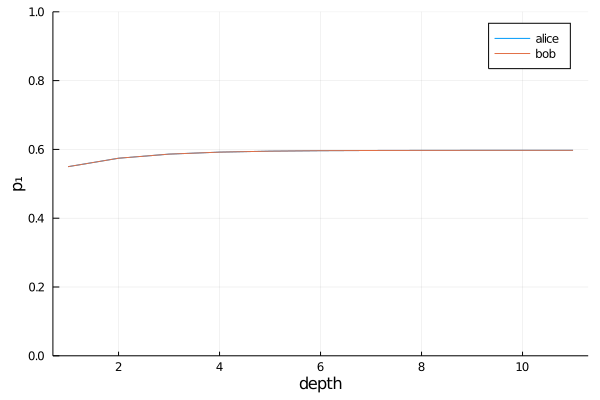

In [5]:
plot_p1(Prefs("alice", 1.2, 1, 1), Prefs("bob", 1.2, 1, 1))

Bob and Alice like each other but have different pub preferences:

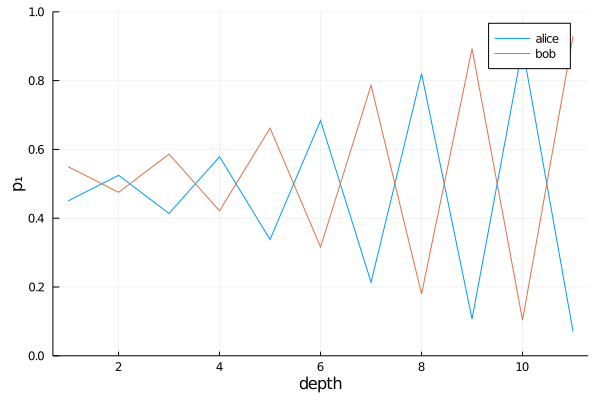

In [6]:
rmeet = 3
plot_p1(Prefs("alice", 1, 1.2, rmeet), Prefs("bob", 1.2, 1, rmeet))

Alice likes Bob, Bob has a crush on Alice:

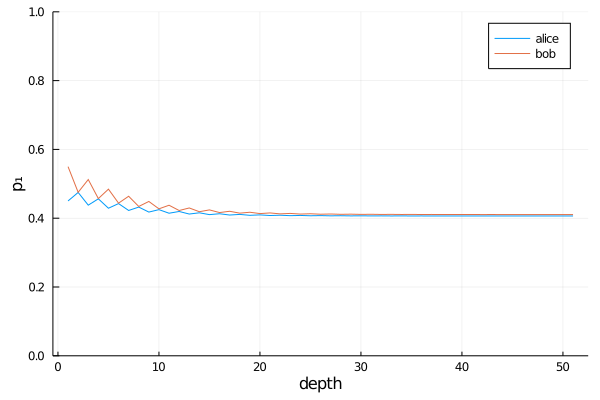

In [7]:
rmeet_bob = 3
plot_p1(Prefs("alice", 1, 1.2, 1), Prefs("bob", 1.2, 1, rmeet_bob), n=50)

#### Sheriff and thief

Bob likes Alice, but Alice really tries to avoid Bob. This is a simplified version to "sheriff and thief" from Iris Seaman's paper. What is interesting here is that if the desire to catch or escape is strong enough, then the reasoning becomes unstable and does not reach and equilibrium.

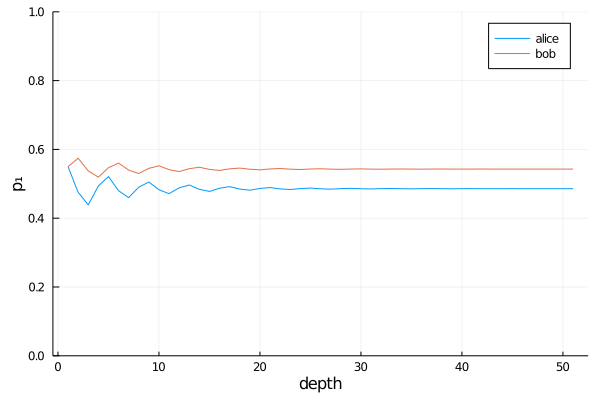

In [8]:
plot_p1(Prefs("alice", 1.2, 1, -3), Prefs("bob", 1.2, 1, 1), n=50)

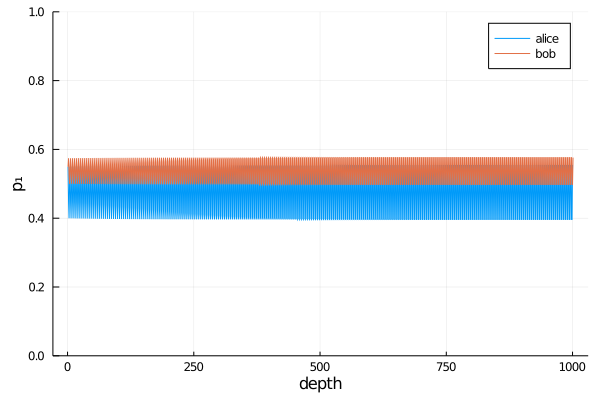

In [9]:
plot_p1(Prefs("alice", 1.2, 1, -4.075), Prefs("bob", 1.2, 1, 1), n=1000)

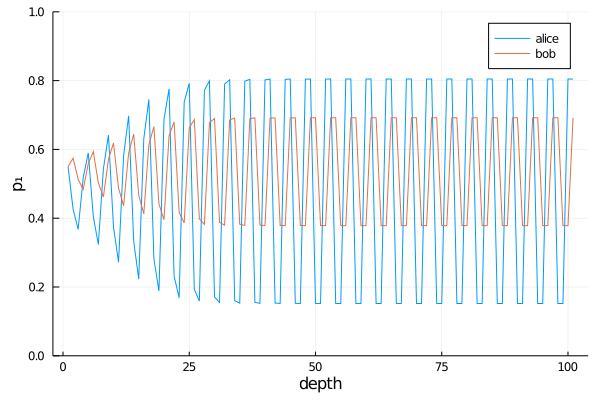

In [10]:
plot_p1(Prefs("alice", 1.2, 1, -5), Prefs("bob", 1.2, 1, 1), n=100)

And so on ... 

## Probabilistic programming for soft rationality

In [11]:
using Gen, Memoize, Random

### Episodic model

In [12]:
@gen function episodic(me::Prefs, buddy::Prefs, depth::Int, niter::Int)
    r1 = me.r1
    r2 = me.r2
    if depth > 0
        at1s = run_episodic(buddy, me, depth-1, niter)
        p1 = sum(at1s)/length(at1s)
        r1 += p1*me.rmeet
        r2 += (1-p1)*me.rmeet
    end
    
    at1 = @trace(bernoulli(0.5), :at1)
    if at1 
        r = r1
    else 
        r = r2
    end
    @trace(bernoulli(exp(r)), :r)
end;

In [13]:
@memoize function run_episodic(me::Prefs, buddy::Prefs, depth::Int, niter=1000)
    observations = Gen.choicemap()
    observations[:r] = true

    trace, _ = Gen.generate(episodic, (me, buddy, depth, niter), observations)
    at1s = []
    for i = 1:niter
        trace, _ = Gen.mh(trace, select(:at1))
        push!(at1s, get_choices(trace)[:at1])
    end
    return at1s
end
empty!(memoize_cache(run_episodic));

In [14]:
function genepisodic(me, buddy, depth, niter=5000)
    nburn = niter%10
    at1s = run_episodic(me, buddy, depth, nburn + niter)[nburn+1:end]
    return sum(at1s)/length(at1s)
end;

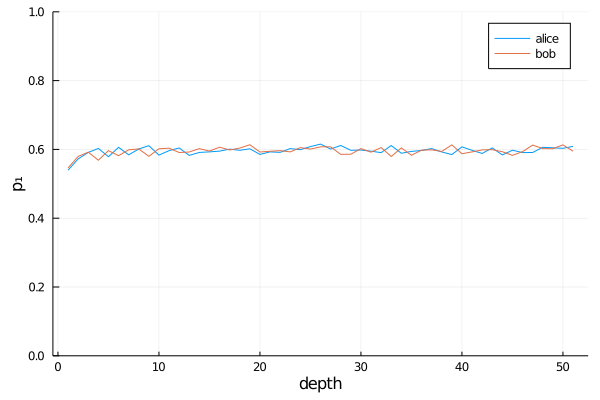

In [15]:
plot_p1(Prefs("alice", 1.2, 1, 1), Prefs("bob", 1.2, 1., 1), n=50, agent=genepisodic)

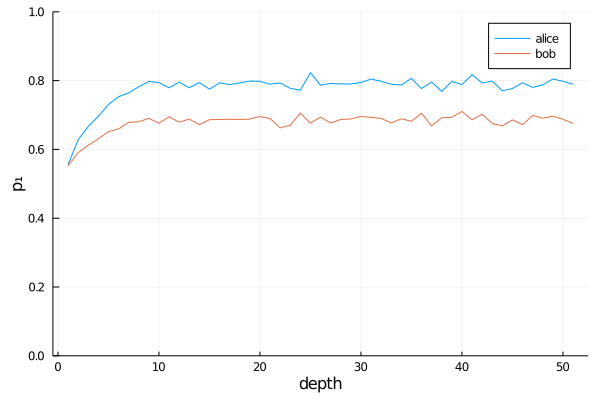

In [16]:
plot_p1(Prefs("alice", 1.2, 1, 3), Prefs("bob", 1.2, 1., 1), n=50, agent=genepisodic)

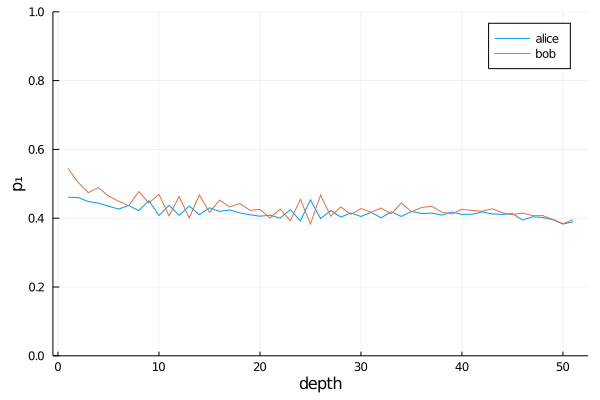

In [17]:
plot_p1(Prefs("alice", 1, 1.2, 1), Prefs("bob", 1.2, 1, 3), n=50, agent=genepisodic)

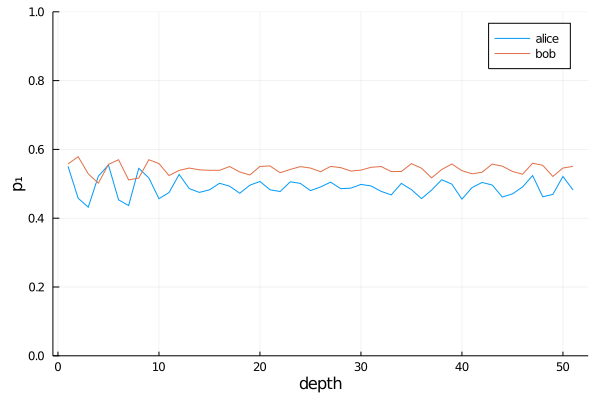

In [18]:
plot_p1(Prefs("alice", 1.2, 1, -3), Prefs("bob", 1.2, 1, 1), n=50, agent=genepisodic)

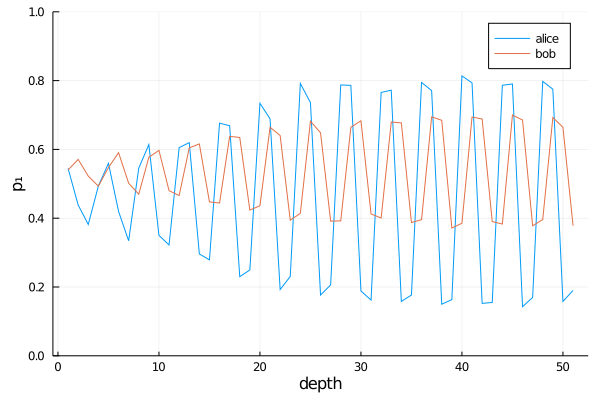

In [19]:
plot_p1(Prefs("alice", 1.2, 1, -5), Prefs("bob", 1.2, 1, 1), n=50, agent=genepisodic)

### Multiround model

We want to infer from the history the preferences of the buddy. Note, that we have two rather than three parameters — due to the way the rewards are used, only differences between rewards count, so $r_2$, for example, can be fixed to 1. 


In [20]:
@gen function multiround(me::Prefs, buddy::Prefs, depth::Int, nmoves::Int, niter::Int)
    # guess buddy's preferences based on their moves
    # (:at1 should be pinned in the choicemap)
    buddy = Prefs(
        buddy.name,
        isa(buddy.r1, Tuple) ? @trace(normal(buddy.r1[1], buddy.r1[2]), :r1) : buddy.r1,
        isa(buddy.r2, Tuple) ? @trace(normal(buddy.r2[1], buddy.r2[2]), :r2) : buddy.r2,
        isa(buddy.rmeet, Tuple) ? @trace(normal(buddy.rmeet[1], buddy.rmeet[2]), :rmeet) : buddy.rmeet)
    for i = 1:nmoves
        # observe buddy's choice
        @trace(episodic(buddy, me, depth, niter), i)
    end
    # make my choice
    @trace(episodic(me, buddy, depth, niter))
end;

Let's simulate a trace to see the overall structure.

In [21]:
trace = simulate(multiround, (Prefs("alice", 1.2, 1, 1), Prefs("bob", 1.2, 1, (0, 1)), 2, 5, 100));
Gen.get_choices(trace)

│
├── :rmeet : 1.0152846599349648
│
├── :at1 : true
│
├── :r : true
│
├── 4
│   │
│   ├── :at1 : true
│   │
│   └── :r : true
│
├── 2
│   │
│   ├── :at1 : true
│   │
│   └── :r : true
│
├── 3
│   │
│   ├── :at1 : true
│   │
│   └── :r : true
│
├── 5
│   │
│   ├── :at1 : false
│   │
│   └── :r : true
│
└── 1
    │
    ├── :at1 : false
    │
    └── :r : true


In [22]:
function run_multiround(me::Prefs, buddy::Prefs, buddyat1s::Vector{Bool}, depth::Int, niter=1000)
    observations = Gen.choicemap()
    observations[:r] = true
    for (i, m) in enumerate(buddyat1s)
        observations[i => :at1] = buddyat1s[i]
        observations[i => :r] = true
    end
    trace, _ = Gen.generate(multiround, (me, buddy, depth, length(buddyat1s), niter), observations)
    at1s = []
    rmeets = []
    for i = 1:niter
        trace, _ = Gen.mh(trace, select(:r1, :r2, :rmeet)) # HMC could be used but does not work due to faulty autodiff
        trace, _ = Gen.mh(trace, select(:at1))
        push!(at1s, get_choices(trace)[:at1])
        push!(rmeets, get_choices(trace)[:rmeet])
    end
    return at1s, rmeets
end;

As a first attempt, we assume that we know the preferences of the buddy w.r.t the pubs, but not how strong they want to meet (or avoid) us. We will pass a tuple (mean, std) instead of
a value as buddy's rmeet.

In [23]:
function genmultiround(me, buddy, buddyat1s, depth, niter=1000)
    niter *= depth+1
    nburn = niter%10
    at1s, rmeets = run_multiround(me, buddy, buddyat1s, depth, nburn + niter)[nburn+1:end]
    return sum(at1s)/length(at1s), sum(rmeets)/length(rmeets)
end;

One can see that on average,  bob is less interested in alice if he choses the second pub. 

In [24]:
me =  Prefs("alice", 1.2, 1, 1);
buddy = Prefs("bob", 1.2, 1, (0, 1));

In [ ]:
first_pub =[genmultiround(me, buddy, repeat([true], 3), 1) for _ in 1:100];

In [ ]:
second_pub =[genmultiround(me, buddy, repeat([false], 3), 1) for _ in 1:100];

In [ ]:
x = [s[2] for s in first_pub]
y = [s[2] for s in second_pub]

scatter(x, y, xlabel="buddy @ first pub", ylabel="buddy @ second pub", label=missing)
plot!([minimum([x;y]), maximum([x;y])], 
       [minimum([x;y]), maximum([x;y])], 
      color="red", label=missing)
plot!(title="rmeet, Pr(rmeet_first > rmeet_second) = $(sum(x .> y)/length(x))")

In [ ]:
drmeet = x .- y
histogram(x .- y, xlabel="rmeet", label="", normalize=:pdf,
          title="rmeet|first - rmeet|second, mean=$(round(sum(drmeet)/length(drmeet), digits=2))")

More effort is needed to make it impressive, but you get the idea.

## Seaman's chaser and runner

In [ ]:
@gen function seaman(me::Prefs, buddy::Prefs, depth::Int)
    r = 0
    
    me_at1 = @trace(bernoulli(0.5), (:at1, 0))
    r += me_at1 ? me.r1 : me.r2
    
    me_at1_i, me_i, buddy_i = me_at1, me, buddy
    for i = 1:depth
        buddy_at1_i = @trace(bernoulli(0.5), (:at1, i))
        r += buddy_at1_i ? buddy.r1 : buddy.r2
        if me_at1_i == buddy_at1_i
            r += me_i.rmeet
        end
        me_at1_i, me_i, buddy_i = buddy_at1_i, buddy_i, me_i
    end
    
    @trace(bernoulli(exp(r)), :r)
end;

In [ ]:
Gen.get_choices(Gen.simulate(seaman, (Prefs("a", 1.2, 1, 1), Prefs("b", 1.2, 1, -1), 3)))

In [ ]:
function run_seaman(me::Prefs, buddy::Prefs, depth::Int, niter::Int)
    observations = Gen.choicemap()
    observations[:r] = true

    trace, _ = Gen.generate(seaman, (me, buddy, depth), observations)
    at1s = []
    sel = []
    for i = 0:depth
        push!(sel, (:at1, i))
    end
    for i = 1:niter
        trace, _ = Gen.mh(trace, select(sel...))
        push!(at1s, get_choices(trace)[(:at1, 0)])
    end
    return at1s
end

In [ ]:
function genseaman(me, buddy, depth, niter=100000)
    niter *= depth + 1
    nburn = niter%10
    at1s = run_seaman(me, buddy, depth, nburn + niter)[nburn+1:end]
    return sum(at1s)/length(at1s)
end;

## Comparing wrong and write agents on collaborative game

### Collaborative

In [ ]:
plot_p1(Prefs("alice", 1.2, 1, 3.075), Prefs("bob", 1, 1.2, 1), n=20, agent=genseaman)

In [ ]:
plot_p1(Prefs("alice", 1.2, 1, 3.075), Prefs("bob", 1, 1.2, 1), n=20, agent=agent)

In [ ]:
plot_p1(Prefs("alice", 1.2, 1, 3.075), Prefs("bob", 1, 1.2, 1), n=20, agent=genepisodic)

### Adversarial, symmetric

In [ ]:
plot_p1(Prefs("alice", 1.2, 1, -1), Prefs("bob", 1.2, 1, 1), n=20, agent=genseaman)

In [ ]:
plot_p1(Prefs("alice", 1.2, 1, -1), Prefs("bob", 1.2, 1, 1), n=20, agent=agent)

In [ ]:
plot_p1(Prefs("alice", 1.2, 1, -1), Prefs("bob", 1.2, 1, 1), n=20, agent=genepisodic)

### Adversarial, asymetric

In [ ]:
plot_p1(Prefs("alice", 1.2, 1, -3), Prefs("bob", 1.2, 1, 1), n=20, agent=genseaman)

In [ ]:
plot_p1(Prefs("alice", 1.2, 1, -3), Prefs("bob", 1.2, 1, 1), n=20, agent=agent)

In [ ]:
plot_p1(Prefs("alice", 1.2, 1, -3), Prefs("bob", 1.2, 1, 1), n=20, agent=genepisodic)